In [1]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.special import sph_harm
from scipy.signal import hilbert
import sound_field_analysis as sfa
import matplotlib.pyplot as plt

In [2]:
def spec_diff(x, y, axis=None):
    if axis is None:
        return 20 * np.abs(np.log10(np.abs(x)) - np.log10(np.abs(y))).mean()
    else:
        return 20 * np.abs(np.log10(np.abs(x)) - np.log10(np.abs(y))).mean(axis)


def sph_harm_all(nMax, az, el):
    # copy from sofia
    degs = np.arange(nMax + 1)
    n = np.repeat(degs, degs * 2 + 1)
    elementNumber = np.arange((nMax + 1) ** 2) + 1
    t = np.floor(np.sqrt(elementNumber - 1)).astype(int)
    m = elementNumber - t * t - t - 1
    mA, azA = np.meshgrid(m, az)
    nA, elA = np.meshgrid(n, el)
    return sph_harm(mA, nA, azA, elA)

def iSpatFT(spherical_coefficients, position_grid):
    spherical_coefficients = np.atleast_2d(spherical_coefficients)
    number_of_coefficients = spherical_coefficients.shape[0]
    order_max = int(np.sqrt(number_of_coefficients) - 1)

    spherical_harmonic_bases = sph_harm_all(order_max, position_grid.azimuth, position_grid.colatitude)
    spherical_harmonic_bases = np.asarray(spherical_harmonic_bases)
    return np.dot(spherical_harmonic_bases, spherical_coefficients.reshape(spherical_harmonic_bases.shape[1], -1)
                  ).reshape(-1, *spherical_coefficients.shape[1:])

def spatFT(data, position_grid, order_max):
    data = np.atleast_2d(data)
    spherical_harmonic_bases = sph_harm_all(order_max, position_grid.azimuth, position_grid.colatitude)
    spherical_harmonic_bases = np.asarray(spherical_harmonic_bases)
    if position_grid.weight is None:
        spherical_harmonic_weighted = np.linalg.pinv(spherical_harmonic_bases)
    else:
        spherical_harmonic_weighted = (np.conj(spherical_harmonic_bases).T * (4 * np.pi * np.asarray(position_grid.weight)))

    return np.dot(spherical_harmonic_weighted, data.reshape(spherical_harmonic_weighted.shape[1], -1)).reshape(-1, *data.shape[1:])

def sh_spec(Pnm):
    number_of_coefficients = Pnm.shape[0]
    order_max = int(np.sqrt(number_of_coefficients) - 1)
    degs = np.arange(order_max + 1)
    n = np.repeat(degs, degs * 2 + 1)
    
    spec = np.empty((order_max + 1, Pnm.shape[1]))
    for i in range(order_max + 1):
        spec[i] = np.sqrt(np.sum(np.abs(Pnm[n == i]) ** 2, 0))
    spec /= spec.max(0)
    return spec

def phase_correct_vector(r, az_lr, col_lr, grid, freqs):
    k = 2 * np.pi * freqs / 343
    cos_theta = np.cos(col_lr) * np.cos(grid.colatitude)[:, None] + \
                np.sin(col_lr) * np.sin(grid.colatitude)[:, None] * np.cos(grid.azimuth[:, None] - az_lr)
    C = np.exp(-1j * k * r * cos_theta[..., None])
    return C

# Load HUTUBS

According to the paper, the SH coefficeints of measured HRTFs are already time-aligned, and this brings some inconveniences when generating sparse sampled HRTF, so I used the simulated data for the following demos, but the same techniques can be used on measured HRTFs, of course.

In [3]:
hutubs_dir = '~/data-disk/Datasets/HUTUBS/HRIRs'
subject_name = []
subject_hrir = []
subject_sph = []

for dir_path, _, files in os.walk(os.path.expanduser(hutubs_dir)):
    for f in files:
        if f[-5:] == '.sofa' and 'simulated' in f:
            name = f.split('_')[0]
            subject_name.append(int(name[2:]))
            
            hrir = sfa.io.read_SOFA_file(os.path.join(dir_path, f))
            subject_hrir.append(np.stack((hrir.l.signal, hrir.r.signal), 1))
            
            hrtf = np.fft.rfft(hrir.l.signal)
            
            sph = loadmat(os.path.join(dir_path, name + '_SHcoefficients_simulated.mat'))
            *Pnm, max_order, n, m, freqs, sr, _, _  = sph['HRIR'][0][0]
            subject_sph.append(np.stack(Pnm, 1))
            
            max_order = np.squeeze(max_order)
            sr = np.squeeze(sr)
            freqs = np.squeeze(freqs)
            grid = hrir.grid
            
            

subject_hrir = np.stack(subject_hrir, 0)
#subject_sph = spatFT(np.fft.rfft(subject_hrir).swapaxes(0, 1), grid, max_order).swapaxes(0, 1)
subject_sph = np.stack(subject_sph, 0)
# subject_name = sorted(subject_name)


open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp72_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp94_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp22_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp10_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk


open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp32_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp75_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp92_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp13_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk


open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp68_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp12_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp9_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/Datasets/HUTUBS/HRIRs/pp55_HRIRs_simulated.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 1730, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0

open SOFA file "/home/ycy/data-disk/

## Calculate Time-of-Arrival

In [4]:
subject_hrtf = np.fft.fft(subject_hrir)
log_mag = np.log(subject_hrtf).real
min_phase = - np.imag(hilbert(log_mag))
min_hrtf = np.exp(log_mag + 1j * min_phase)
toa = np.argmax(np.fft.ifft(subject_hrtf * min_hrtf.conj()).real, axis=-1)

## Fit the data with a rigid sphere model

In [5]:
def toa_func(P, r, az0, az1, incli0, incli1, delta):
    E = sfa.utils.sph2cart([[az0, az1], [incli0, incli1], [r, r]]).T
    R = np.sqrt(np.sum(P ** 2, 1))

    PE_cos = P @ E.T / R[:, None] / np.sqrt(np.sum(E ** 2, 1))
    path_length = np.where(PE_cos > 0, R[:, None] - r *  PE_cos, R[:, None] + r * np.arcsin(-PE_cos))
    y = path_length / 343 * sr + delta
    return y.ravel()

P_xyz = sfa.utils.sph2cart((grid.azimuth, grid.colatitude, grid.radius)).T
subject_sphere_params = []
for i in range(toa.shape[0]):
    popt, _ = curve_fit(toa_func, P_xyz, toa[i].ravel(),
                        p0=(0.0825, 0.5 * np.pi, 1.5 * np.pi, 0.5 * np.pi, 0.5 * np.pi,0),
                        bounds=([0, 0, np.pi, 0, 0, -np.inf], [np.inf, np.pi, 2 * np.pi, np.pi, np.pi, np.inf]))
    delay = toa_func(P_xyz, *popt).mean() / sr - popt[-1] / sr
    subject_sphere_params.append(popt.tolist() + [delay])
subject_sphere_params = np.stack(subject_sphere_params, 0)

Average of rigid sphere radius: 9.096461934867667 cm
Standard deviation of rigid sphere radius: 0.373705942562396 cm
Average of IR offset: -2.8728041928910244 ms
Standard deviation of IR offset: 0.005354444926929321 ms
Average left ear position: 89.35630731025347 94.02739959473963 (az/co)
Average right ear position: -89.23086905515441 94.20537617960434 (az/co)
Average delay: 4.295712421692891 ms


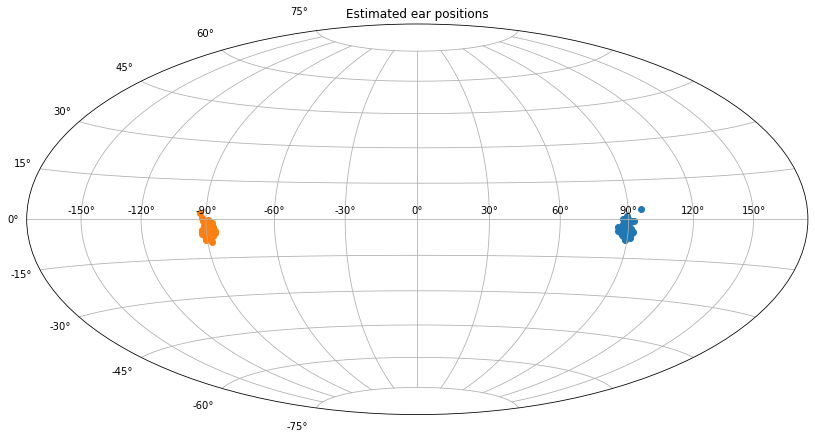

In [6]:
print("Average of rigid sphere radius:", subject_sphere_params[:, 0].mean() * 100, "cm")
print("Standard deviation of rigid sphere radius:", subject_sphere_params[:, 0].std() * 100, "cm")
print("Average of IR offset:", subject_sphere_params[:, -2].mean() / sr * 1000, "ms")
print("Standard deviation of IR offset:", subject_sphere_params[:, -2].std() / sr * 1000, "ms")
print("Average left ear position:", subject_sphere_params[:, 1].mean() / np.pi * 180, subject_sphere_params[:, 3].mean() / np.pi * 180, "(az/co)")
print("Average right ear position:", subject_sphere_params[:, 2].mean() / np.pi * 180 - 360, subject_sphere_params[:, 4].mean() / np.pi * 180, "(az/co)")
print("Average delay:", subject_sphere_params[:, -1].mean() * 1000, "ms")



fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='hammer')
ax.set_title("Estimated ear positions")
ax.grid()
ax.scatter(subject_sphere_params[:, 1], 0.5 * np.pi - subject_sphere_params[:, 3])
ax.scatter(subject_sphere_params[:, 2] - 2 * np.pi, 0.5 * np.pi - subject_sphere_params[:, 4])
plt.show()

# SUpDEq

## Get equalization datasets

In [7]:
custom_eq = []
nfft = len(freqs) * 2 - 2
for sphere_param in subject_sphere_params:
    ac = sfa.io.ArrayConfiguration(sphere_param[0], 'rigid', 'omni')
    left_eq = sfa.gen.ideal_wave(35, sr, sphere_param[1], sphere_param[3], ac, NFFT=nfft, delay=0)
    right_eq = sfa.gen.ideal_wave(35, sr, sphere_param[2], sphere_param[4], ac, NFFT=nfft, delay=0)
    custom_eq.append(np.stack((left_eq, right_eq), 1))

custom_eq = np.stack(custom_eq, 0)

## Redo Figure 2. (c)

4 4.915667321958767
7 4.48408401490741
10 4.1064677788115205
4 3.1148652584175327
7 2.02727438941457
10 1.4488453300314659


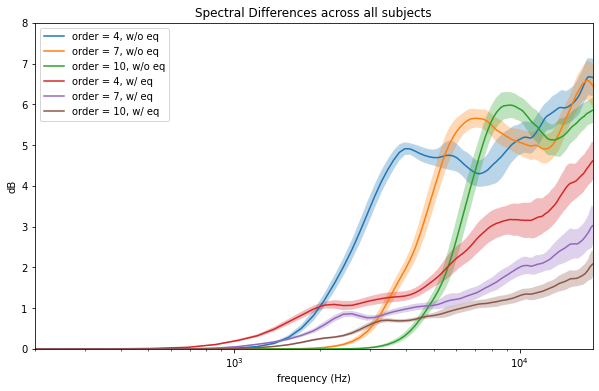

In [8]:
max_order = 11
target_grid = grid #sfa.gen.lebedev(max_order)

target_hrtf = iSpatFT(subject_sph.swapaxes(0, 1), target_grid).swapaxes(0, 1)


fig = plt.figure(figsize=(10, 6))

for with_eq in [False, True]:
    for N in [4, 7, 10]:
        sparse_grid = sfa.gen.lebedev(N)
        lr_hrtf = iSpatFT(subject_sph.swapaxes(0, 1), sparse_grid)
        
        if with_eq:
            lr_hrtf /= iSpatFT(custom_eq.swapaxes(0, 1), sparse_grid)
        sparse_sph = spatFT(lr_hrtf, sparse_grid, N)
        hr_hrtf = iSpatFT(sparse_sph, target_grid).swapaxes(0, 1)
        if with_eq:
            hr_hrtf *= iSpatFT(custom_eq.swapaxes(0, 1), target_grid).swapaxes(0, 1)

        diff = spec_diff(hr_hrtf, target_hrtf, axis=(1, 2))
        print(N, diff.mean())
        mu, std = diff.mean(0), diff.std(0)
        label=f"order = {N}"
        if with_eq:
            label += ", w/ eq"
        else:
            label += ", w/o eq"
        plt.plot(freqs, mu, label=label)
        plt.fill_between(freqs, mu - std, mu + std, edgecolor='none', alpha=0.3)

plt.legend()
plt.title("Spectral Differences across all subjects")
plt.xscale('log')
plt.xlim([200, 18000])
plt.ylim([0, 8])
plt.ylabel("dB")
plt.xlabel("frequency (Hz)")
plt.show()

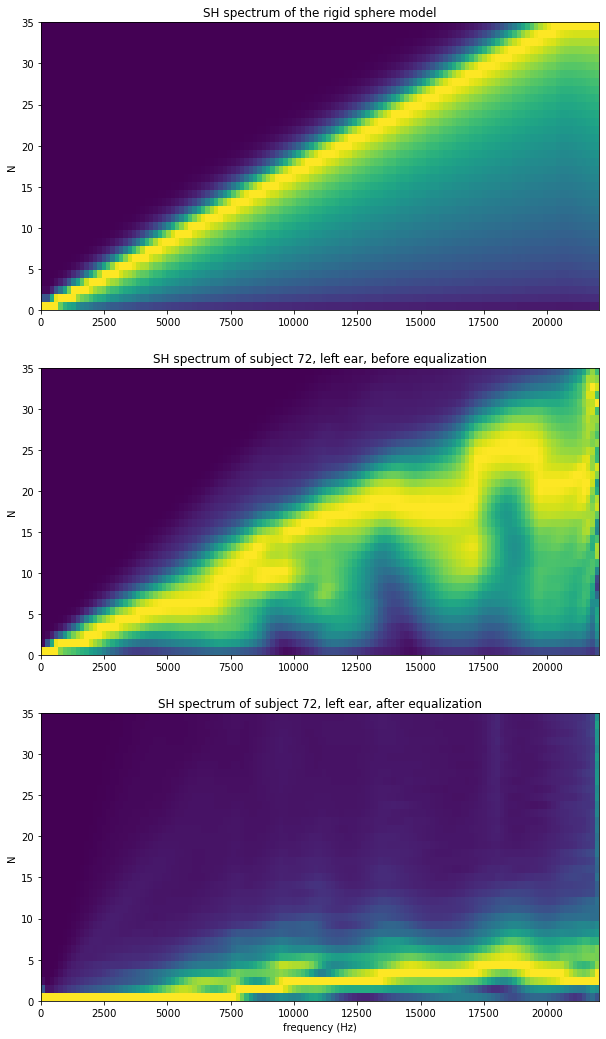

In [9]:
x = subject_hrir[0, :, 0]
hrtf = np.fft.rfft(x)
Pnm_before = spatFT(hrtf, grid, 35)
Pnm_after = spatFT(hrtf / iSpatFT(custom_eq[0, :, 0], grid), grid, 35)

fig = plt.figure(figsize=(10, 18))
ax = plt.subplot(311)
plt.imshow(sh_spec(custom_eq[0, :, 0]), aspect='auto', origin='lower', extent=[0, sr / 2, 0, 35])
plt.title(f"SH spectrum of the rigid sphere model")
plt.ylabel("N")
plt.subplot(312, sharex=ax)
plt.imshow(sh_spec(Pnm_before), aspect='auto', origin='lower', extent=[0, sr / 2, 0, 35])
plt.title(f"SH spectrum of subject {subject_name[0]}, left ear, before equalization")
plt.ylabel("N")
plt.subplot(313, sharex=ax)
plt.imshow(sh_spec(Pnm_after), aspect='auto', origin='lower', extent=[0, sr / 2, 0, 35])
plt.title(f"SH spectrum of subject {subject_name[0]}, left ear, after equalization")
plt.ylabel("N")
plt.xlabel("frequency (Hz)")
plt.show()

# Phase-Correction

4 4.915667321958767
7 4.48408401490741
10 4.1064677788115205
4 3.7850795105072357
7 2.2644712611240703
10 1.4910603650980805


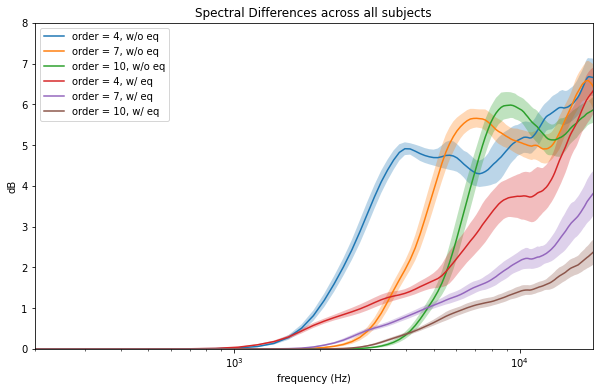

In [10]:
fig = plt.figure(figsize=(10, 6))

for with_eq in [False, True]:
    for N in [4, 7, 10]:
        sparse_grid = sfa.gen.lebedev(N)

        result = []
        for i, sphere_param in enumerate(subject_sphere_params):
            lr_hrtf = iSpatFT(subject_sph[i], sparse_grid)
            if with_eq:
                C_lr = phase_correct_vector(sphere_param[0], 
                                             np.array(sphere_param[1:3]),
                                             np.array(sphere_param[3:5]),
                                             sparse_grid, freqs)
                lr_hrtf *= C_lr

            sparse_sph = spatFT(lr_hrtf, sparse_grid, N)
            hr_hrtf = iSpatFT(sparse_sph, target_grid)
            if with_eq:
                C_hr = phase_correct_vector(sphere_param[0], 
                                             np.array(sphere_param[1:3]),
                                             np.array(sphere_param[3:5]),
                                             target_grid, freqs)
                hr_hrtf *= C_hr.conj()
            result.append(hr_hrtf)
        
        hr_hrtf = np.stack(result, 0)
        diff = spec_diff(hr_hrtf, target_hrtf, axis=(1, 2))
        print(N, diff.mean())
        mu, std = diff.mean(0), diff.std(0)
        label=f"order = {N}"
        if with_eq:
            label += ", w/ eq"
        else:
            label += ", w/o eq"
        plt.plot(freqs, mu, label=label)
        plt.fill_between(freqs, mu - std, mu + std, edgecolor='none', alpha=0.3)

plt.legend()
plt.title("Spectral Differences across all subjects")
plt.xscale('log')
plt.xlim([200, 18000])
plt.ylim([0, 8])
plt.ylabel("dB")
plt.xlabel("frequency (Hz)")
plt.show()

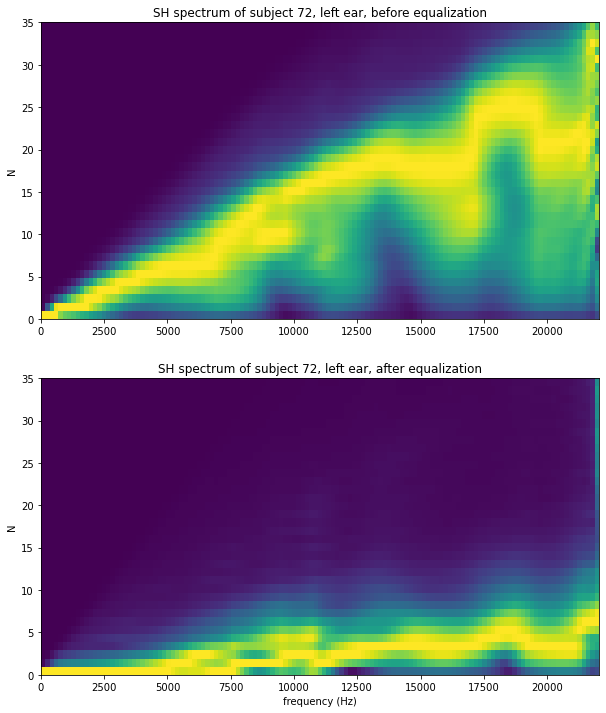

In [12]:
Pnm_before = spatFT(hrtf, grid, 35)

C = phase_correct_vector(subject_sphere_params[0, 0], 
                         subject_sphere_params[0, 1:3],
                         subject_sphere_params[0, 3:5],
                         grid, freqs)
Pnm_after = spatFT(hrtf * C[:, 0], grid, 35)

fig = plt.figure(figsize=(10, 12))
ax = plt.subplot(211)
plt.imshow(sh_spec(Pnm_before), aspect='auto', origin='lower', extent=[0, sr / 2, 0, 35])
plt.title(f"SH spectrum of subject {subject_name[0]}, left ear, before equalization")
plt.ylabel("N")
plt.subplot(212, sharex=ax)
plt.imshow(sh_spec(Pnm_after), aspect='auto', origin='lower', extent=[0, sr / 2, 0, 35])
plt.title(f"SH spectrum of subject {subject_name[0]}, left ear, after equalization")
plt.ylabel("N")
plt.xlabel("frequency (Hz)")
plt.show()